# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Load in a Binaural Recording</h1>

Set up where the data is located. In this case, we'll use the sample recordings located under the `Field Rec` folder.

In [1]:
from pathlib import Path
wav_folder = Path().cwd().joinpath("Field Rec")

Ensuring that Soundscapy knows exactly how loud your recordings were onsite is crucial to getting correct answers. If you used equipment such as the Head Acoustics SqoBold, and were careful about how the recordings are exported to .wav, then they may already be correctly adjusted (as ours are here). However its best to be safe and calibrate each signal to their real-world dB level. To do this, we load in a .json that contains the per-channel correct dB $L_{eq}$ level.

In [2]:
import json

levels = wav_folder.joinpath("Levels.json")

with open("Field Rec/Levels.json") as f:
    levels= json.load(f)

list(levels.items())

[('1m', {'Left': 62.573, 'Right': 62.573}),
 ('2m', {'Left': 58.27, 'Right': 58.27}),
 ('3m', {'Left': 55.83, 'Right': 55.83}),
 ('5m', {'Left': 53.93, 'Right': 53.93}),
 ('10m', {'Left': 50.43, 'Right': 50.43}),
 ('15m', {'Left': 50.13, 'Right': 50.13})]

Load in a binaural wav signal. We can use the `plot` function provided by the `acoustics.Signal` super-class.

In [3]:
from soundscapy import Binaural

# Loading (you can load any wave under the Field Rec folder. We Chose "10m.wav")
binaural_wav = wav_folder.joinpath("10m.wav")
b = Binaural.from_wav(binaural_wav)

# Calibration
decibel = (levels[b.recording]["Left"], levels[b.recording]["Left"])

b = Binaural.from_wav(binaural_wav, calibrate_to=decibel)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\acoustics\_signal.py:1048: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(filename)


# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Run All Soundscapy Tests</h1>

In [4]:
from soundscapy import AnalysisSettings
from soundscapy.analysis.binaural import prep_multiindex_df, process_all_metrics

df = prep_multiindex_df(levels, incl_metric=True)

ex_settings = AnalysisSettings.from_yaml(Path("ex_settings.yaml"))

b.process_all_metrics(ex_settings, verbose=True)

Processing 10m
 - Calculating Python Acoustics metrics: LAeq
 - Calculating MoSQITo metrics: `sharpness_din` from `loudness_zwtv`
 - Calculating MoSQITo metric: roughness_dw


LAeq     N_avg     S_avg     R_avg
Recording Channel                                         
10m       Left     48.947358  5.590374  1.587287  0.035286
          Right    45.529581  4.577172  1.493431  0.030562

In [5]:
import json
from pathlib import Path
from soundscapy import AnalysisSettings
from soundscapy.analysis.binaural import prep_multiindex_df
from soundscapy.analysis.parallel_processing import parallel_process

# Redefine path etc. just for the example
wav_folder = Path().cwd().joinpath("Field Rec")
levels = wav_folder.joinpath("Levels.json")

with open(levels) as f:
    levels = json.load(f)

df = prep_multiindex_df(levels, incl_metric=False)
ex_settings = AnalysisSettings.from_yaml(Path("ex_settings.yaml"))

df = parallel_process(
    wav_folder.glob("*.wav"), df, levels, ex_settings, verbose=True
)



Processing files:   0%|          | 0/6 [00:00<?, ?it/s]

Processing files: 100%|██████████| 6/6 [25:45<00:00, 257.59s/it]   


In [7]:
df

LAeq      N_avg     S_avg     R_avg
Recording Channel                                          
1m        Left     62.466480  12.207606  1.692523  0.052048
          Right    61.486554  12.280902  1.711750  0.052555
2m        Left     58.142880  10.222816  1.744587  0.049520
          Right    56.699480   9.987620  1.709295  0.044847
3m        Left     55.482109   8.458704  1.739835  0.049725
          Right    53.034386   7.814338  1.687280  0.041296
5m        Left     53.222831   7.358445  1.758980  0.060846
          Right    50.300400   6.521064  1.711843  0.039595
10m       Left     48.947358   5.590374  1.587287  0.035286
          Right    45.529581   4.577172  1.493431  0.030562
15m       Left     45.188408   4.441168  1.458282  0.029973
          Right    42.258942   3.656647  1.390105  0.026553

<h1 style="color:orange ; font-weight: bold; font-style: italic;">Save the File as an Excel File</h1>

In [6]:
from datetime import datetime
df.to_excel("test.xlsx")

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Plot Binaural Graph</h1>

<Axes: title={'center': 'Binaural - 10m.wav'}, xlabel='$t$ in s', ylabel='$x$ in -'>

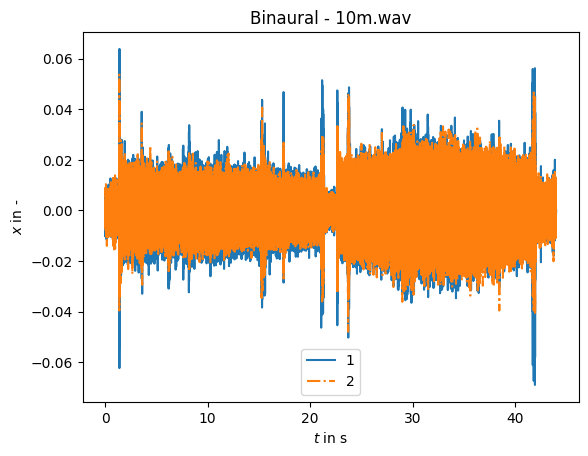

In [6]:
# Plotting
b.plot(title='Binaural - ' + binaural_wav.name)

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Plot Mel-Frequency Spectrogram</h1>

[Text(0.5, 1.0, 'Mel-frequency spectrogram - 10m.wav')]

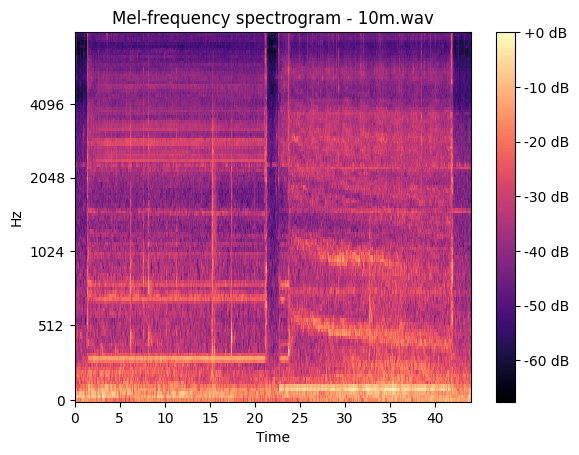

In [7]:
import librosa
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

wav_folder = Path().cwd().joinpath("Field Rec")

# Loading (you can load any wave under the Field Rec folder. We Chose "10m.wav")
binaural_wav = wav_folder.joinpath("10m.wav")
   
y, sr = librosa.load(binaural_wav)
librosa.feature.melspectrogram(y=y, sr=sr)


D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)

# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram - ' + binaural_wav.name)

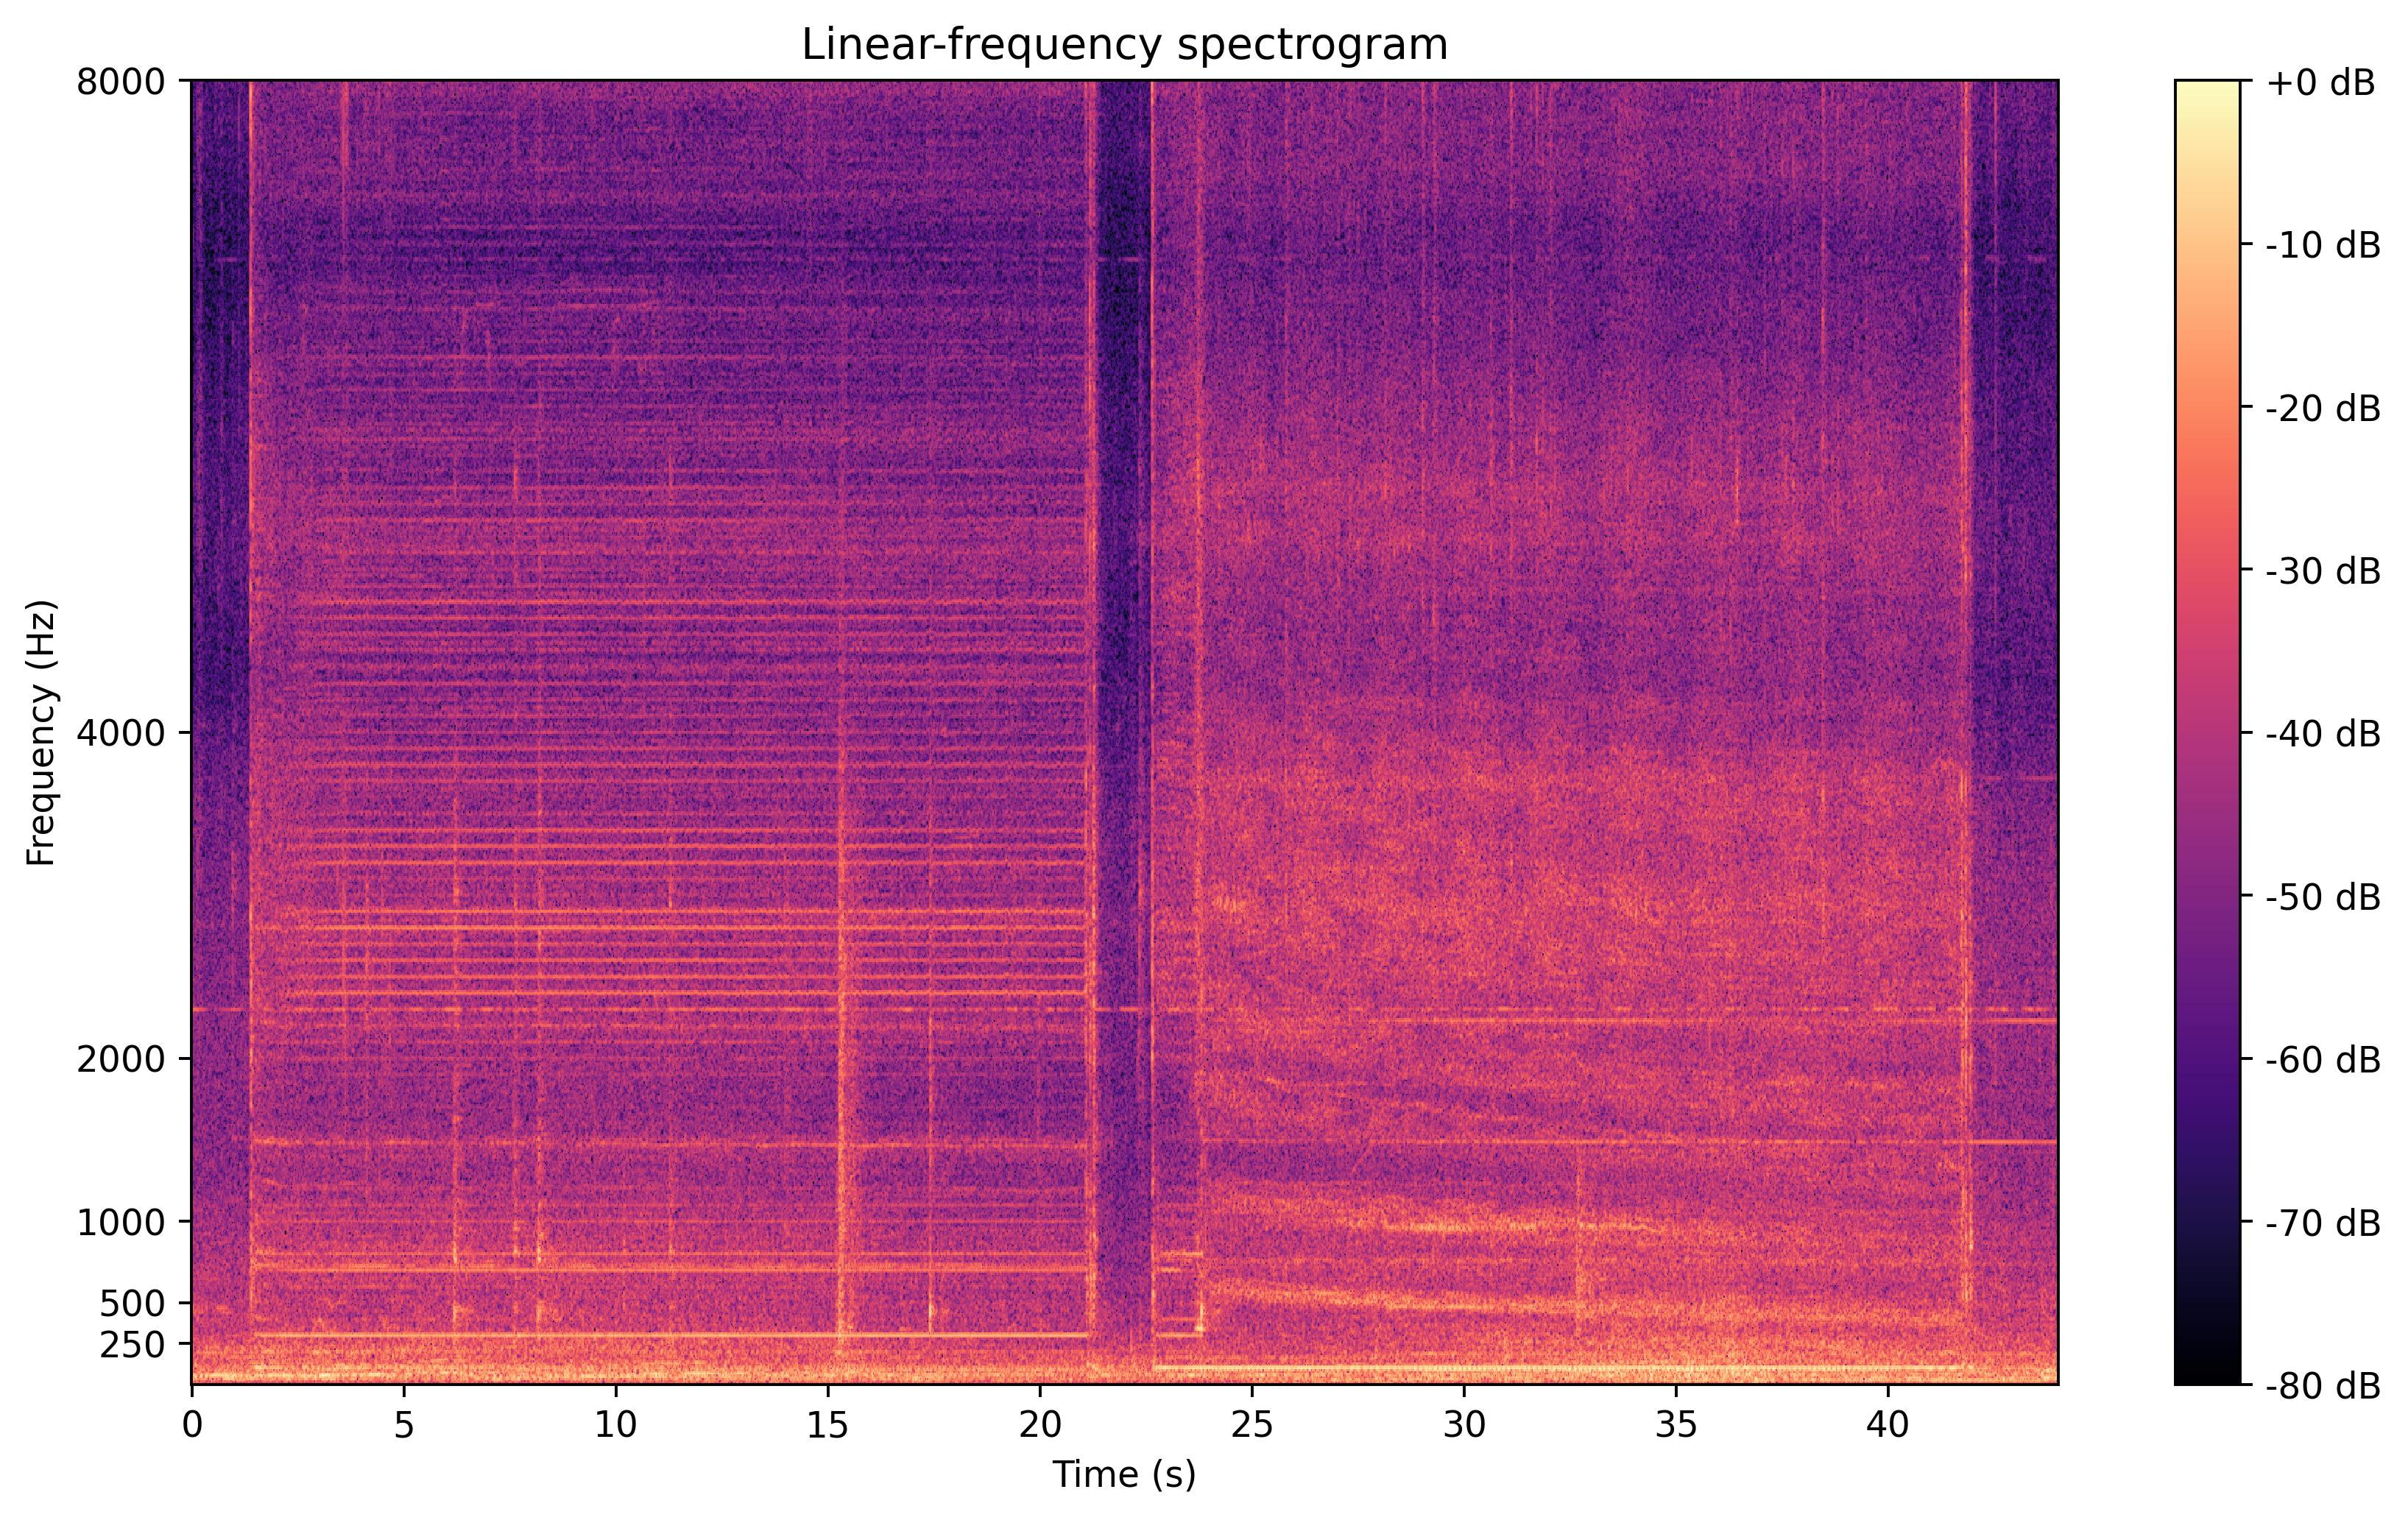

In [11]:
import librosa
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


wav_folder = Path().cwd().joinpath("Field Rec")

# Loading (you can load any wave under the Field Rec folder. We Chose "10m.wav")
binaural_wav = wav_folder.joinpath("10m.wav")
   
y, sr = librosa.load(binaural_wav)

# Compute spectrogram
D = np.abs(librosa.stft(y))
spectrogram = librosa.amplitude_to_db(D, ref=np.max)

# Display spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0,8000)
plt.yticks([250,500,1000,2000,4000,8000])
plt.tight_layout()
plt.show()


# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Plot Magnitude for Specific Frequencies</h1>

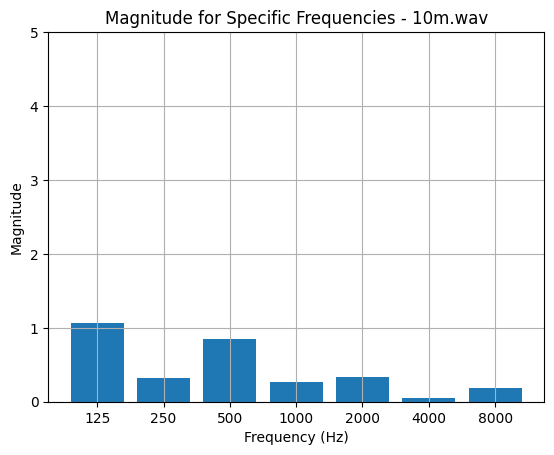

In [9]:
import librosa
import numpy as np
import matplotlib.pyplot as plt


sound_data, sampling_rate = librosa.load(binaural_wav, sr=None)
# Calculate the FFT magnitude
fft_magnitude = np.abs(np.fft.fft(sound_data))

# Frequencies of interest
frequencies = [125, 250, 500, 1000, 2000, 4000, 8000]

# Find the indices corresponding to the frequencies of interest
indices = []
for freq in frequencies:
    index = int(freq * len(fft_magnitude) / sampling_rate)
    indices.append(index)

# Extract the magnitudes for the frequencies of interest
magnitudes = fft_magnitude[indices]

# Plot a bar chart of the magnitudes
plt.bar(np.arange(len(frequencies)), magnitudes)
plt.xticks(np.arange(len(frequencies)), frequencies)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.ylim(0, 5)
plt.title('Magnitude for Specific Frequencies - ' + binaural_wav.name)
plt.grid(True)
plt.show()


# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Loading Questionnaire Answers (PAQs)</h1>

In [2]:
import soundscapy
import pandas as pd
import matplotlib.pyplot as plt

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.width', None)        # Set width to fit the entire DataFrame

df1 = pd.read_excel("Book1.xlsx", sheet_name="Sheet1")
df1

Participint   Age  RecordID  GroupID  SessionID Gender LocationID  \
0         Max  28.0         1        1          1      M        R1c   
1         Max  28.0         2        1          1      M        R1m   
2         Max  28.0         3        1          1      M        R1o   
3      Amanda  33.0         4        1          1      F        R1c   
4      Amanda  33.0         5        1          1      F        R1m   
5      Amanda  33.0         6        1          1      F        R1o   
6     Maraile   NaN         7        1          1      F        R1c   
7     Maraile   NaN         8        1          1      F        R1m   
8     Maraile   NaN         9        1          1      F        R1o   

        Date      Time  pleasant  chaotic  vibrant  uneventful  calm  \
0 2023-07-19  09:40:00         5        1        1           5     5   
1 2023-07-19  09:44:00         1        1        1           3     1   
2 2023-07-19  09:46:00         5        1        1           5     5   
3 2023-07-19  09:55:00         3        2        1           4     4   
4 2023-07-19  09:58:00         1        4        2           1     1   
5 2023-07-19  10:00:00         4        1        1           4     4   
6 2023-07-19  10:08:00         4        1        3           3     4   
7 2023-07-19  10:10:00         2        3        2           3     1   
8 2023-07-19  10:12:00         4        1        3           2     4   

   annoying  eventful  monotonous  
0         1         1           2  
1         4         2           5  
2         1         1           3  
3         1         1           4  
4         5         4           1  
5         1         3           4  
6         1         3           2  
7         4         3           3  
8         1         3           2

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Validating the Dataset</h1>

In [2]:
# 'df' will contain the validated DataFrame
# 'excl' will contain any excluded data or information returned by the method

df, excl = df1.isd.validate_dataset()
df

Renaming PAQ columns.
Checking PAQ data quality.
PAQ quality confirmed. No rows dropped.


Participint   Age  RecordID  GroupID  SessionID Gender LocationID  \
0         Max  28.0         1        1          1      M        R1c   
1         Max  28.0         2        1          1      M        R1m   
2         Max  28.0         3        1          1      M        R1o   
3      Amanda  33.0         4        1          1      F        R1c   
4      Amanda  33.0         5        1          1      F        R1m   
5      Amanda  33.0         6        1          1      F        R1o   
6     Maraile   NaN         7        1          1      F        R1c   
7     Maraile   NaN         8        1          1      F        R1m   
8     Maraile   NaN         9        1          1      F        R1o   

        Date      Time  PAQ1  PAQ4  PAQ2  PAQ7  PAQ8  PAQ5  PAQ3  PAQ6  
0 2023-07-19  09:40:00     5     1     1     5     5     1     1     2  
1 2023-07-19  09:44:00     1     1     1     3     1     4     2     5  
2 2023-07-19  09:46:00     5     1     1     5     5     1     1     3  
3 2023-07-19  09:55:00     3     2     1     4     4     1     1     4  
4 2023-07-19  09:58:00     1     4     2     1     1     5     4     1  
5 2023-07-19  10:00:00     4     1     1     4     4     1     3     4  
6 2023-07-19  10:08:00     4     1     3     3     4     1     3     2  
7 2023-07-19  10:10:00     2     3     2     3     1     4     3     3  
8 2023-07-19  10:12:00     4     1     3     2     4     1     3     2

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Calculating the ISOPleasant and ISOEventful Coordinate Values</h1>

In [3]:
df = df.sspy.return_paqs()
df

RecordID  GroupID  SessionID LocationID  PAQ1  PAQ2  PAQ3  PAQ4  PAQ5  \
0         1        1          1        R1c     5     1     1     1     1   
1         2        1          1        R1m     1     1     2     1     4   
2         3        1          1        R1o     5     1     1     1     1   
3         4        1          1        R1c     3     1     1     2     1   
4         5        1          1        R1m     1     2     4     4     5   
5         6        1          1        R1o     4     1     3     1     1   
6         7        1          1        R1c     4     3     3     1     1   
7         8        1          1        R1m     2     2     3     3     4   
8         9        1          1        R1o     4     3     3     1     1   

   PAQ6  PAQ7  PAQ8  
0     2     5     5  
1     5     3     1  
2     3     5     5  
3     4     4     4  
4     1     1     1  
5     4     4     4  
6     2     3     4  
7     3     3     1  
8     2     2     4

In [4]:
df = df.sspy.add_paq_coords()
df

RecordID  GroupID  SessionID LocationID  PAQ1  PAQ2  PAQ3  PAQ4  PAQ5  \
0         1        1          1        R1c     5     1     1     1     1   
1         2        1          1        R1m     1     1     2     1     4   
2         3        1          1        R1o     5     1     1     1     1   
3         4        1          1        R1c     3     1     1     2     1   
4         5        1          1        R1m     1     2     4     4     5   
5         6        1          1        R1o     4     1     3     1     1   
6         7        1          1        R1c     4     3     3     1     1   
7         8        1          1        R1m     2     2     3     3     4   
8         9        1          1        R1o     4     3     3     1     1   

   PAQ6  PAQ7  PAQ8  ISOPleasant  ISOEventful  
0     2     5     5     0.633883    -0.780330  
1     5     3     1    -0.603553    -0.396447  
2     3     5     5     0.560660    -0.853553  
3     4     4     4     0.133883    -0.676777  
4     1     1     1    -0.560660     0.603553  
5     4     4     4     0.310660    -0.542893  
6     2     3     4     0.603553    -0.146447  
7     3     3     1    -0.426777     0.073223  
8     2     2     4     0.603553    -0.042893

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Plotting</h1>

<h3 style="color:white ; font-weight: bold; font-style: italic;">A: Plotting Functions for Visualising Circumplex Data</h3>

## <h2 style="color:#FFA500 ; font-weight: bold; font-style: italic;">1) Scatter Plots</h2>

<Axes: title={'center': 'All Location'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

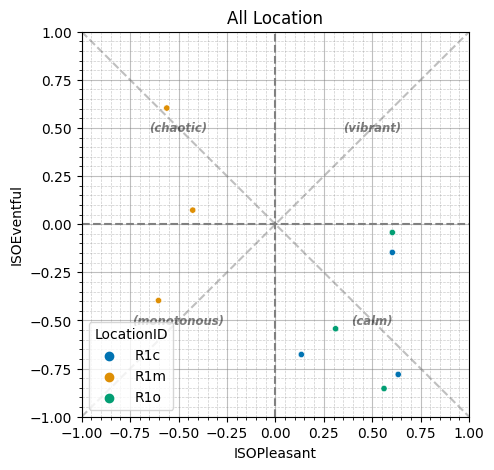

In [5]:
df.sspy.scatter(hue='LocationID', s=20, title='All Location', diagonal_lines=True)

<h2 style="color:#FFA500 ; font-weight: bold; font-style: italic;">2) Distribution (Density) Plots</h2>

The real power of `Soundscapy` is in creating plots of the distribution of soundscape assessments. The interface for doing this is the same as the scatter plots above.

As we said, this is particularly useful for comparing different soundscapes. So let's see how we can plot three different soundscapes at once.

<Axes: title={'center': 'Comparison of the Soundscapes of Three Locations\n'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

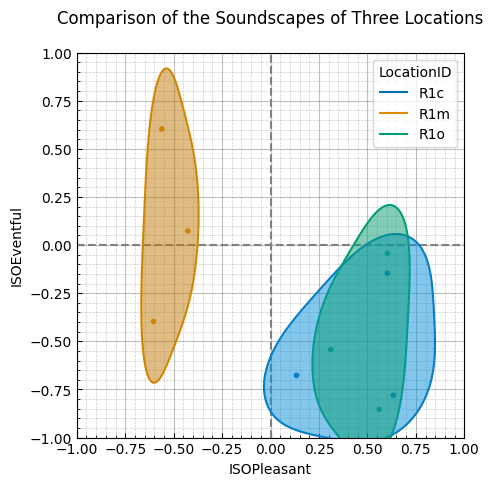

In [6]:
df.isd.filter_location_ids(["R1c", "R1o", "R1m"]).sspy.density(
    title="Comparison of the Soundscapes of Three Locations\n",
    hue="LocationID",
    density_type="simple",
    incl_scatter=True,
    #palette="husl",
)

<h2 style="color:#FFA500 ; font-weight: bold; font-style: italic;">3) Jointplot</h2>

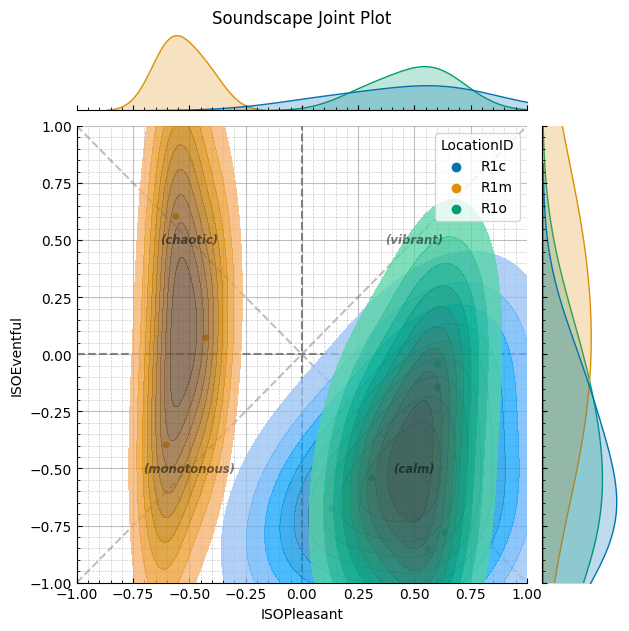

In [7]:
df.isd.filter_location_ids(["R1c", "R1m", "R1o"]).sspy.jointplot(hue="LocationID", diagonal_lines=True, marginal_kind="kde", density_type="full")

<h3 style="color:white ; font-weight: bold; font-style: italic;">B: Plotting Functions for Visualising Likert Scale Data</h3>


#### Generate a radar/spider plot of PAQ values using paq_radar_plot function


<PolarAxes: >

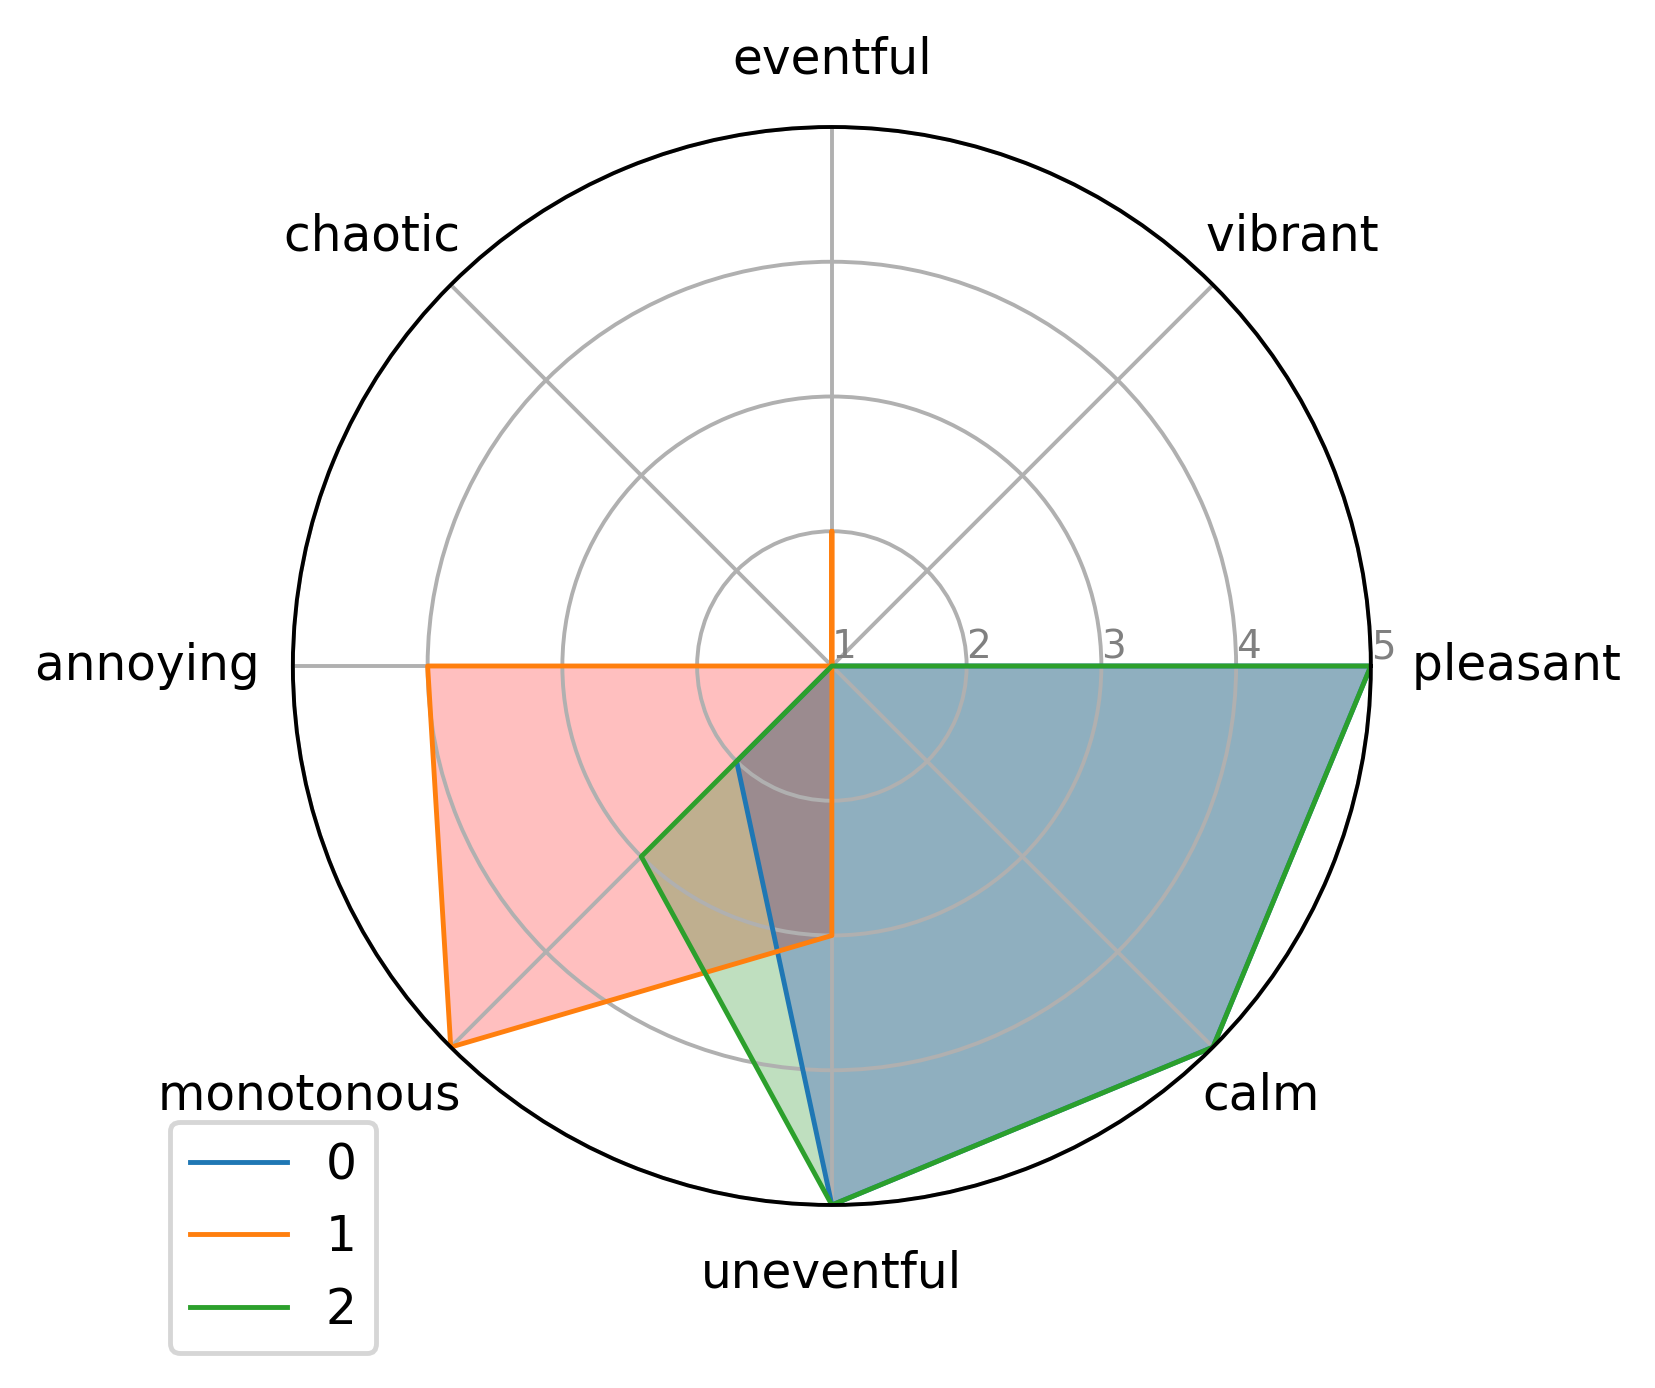

In [3]:
# imports
import pandas as pd
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4, 4))
plt.rcParams["figure.dpi"] = 350
df1.isd.filter_location_ids(["R1c", "R1m", "R1o"]).head(3).sspy.paq_radar()

# <h1 style="color:#AED6F1 ; font-weight: bold; font-style: italic;">Statistical Analysis of the ISD Dataset</h1>

In [9]:
results = df.isd.soundscapy_describe()
results

count  ISOPleasant  ISOEventful  pleasant  eventful  vibrant  chaotic  \
R1c      3        0.457       -0.535       1.0     0.000      0.0    0.000   
R1m      3       -0.530        0.093       0.0     0.667      0.0    0.667   
R1o      3        0.492       -0.480       1.0     0.000      0.0    0.000   

     monotonous  calm  
R1c       0.000   1.0  
R1m       0.333   0.0  
R1o       0.000   1.0

In [10]:
df.describe()

RecordID  GroupID  SessionID      PAQ1      PAQ2      PAQ3      PAQ4  \
count  9.000000      9.0        9.0  9.000000  9.000000  9.000000  9.000000   
mean   5.000000      1.0        1.0  3.222222  1.666667  2.333333  1.666667   
std    2.738613      0.0        0.0  1.563472  0.866025  1.118034  1.118034   
min    1.000000      1.0        1.0  1.000000  1.000000  1.000000  1.000000   
25%    3.000000      1.0        1.0  2.000000  1.000000  1.000000  1.000000   
50%    5.000000      1.0        1.0  4.000000  1.000000  3.000000  1.000000   
75%    7.000000      1.0        1.0  4.000000  2.000000  3.000000  2.000000   
max    9.000000      1.0        1.0  5.000000  3.000000  4.000000  4.000000   

           PAQ5      PAQ6      PAQ7      PAQ8  ISOPleasant  ISOEventful  
count  9.000000  9.000000  9.000000  9.000000     9.000000     9.000000  
mean   2.111111  2.888889  3.333333  3.222222     0.139467    -0.306951  
std    1.691482  1.269296  1.322876  1.715938     0.529721     0.473333  
min    1.000000  1.000000  1.000000  1.000000    -0.603553    -0.853553  
25%    1.000000  2.000000  3.000000  1.000000    -0.426777    -0.676777  
50%    1.000000  3.000000  3.000000  4.000000     0.310660    -0.396447  
75%    4.000000  4.000000  4.000000  4.000000     0.603553    -0.042893  
max    5.000000  5.000000  5.000000  5.000000     0.633883     0.603553

<Axes: title={'center': 'Soundscape Scatter Plot'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

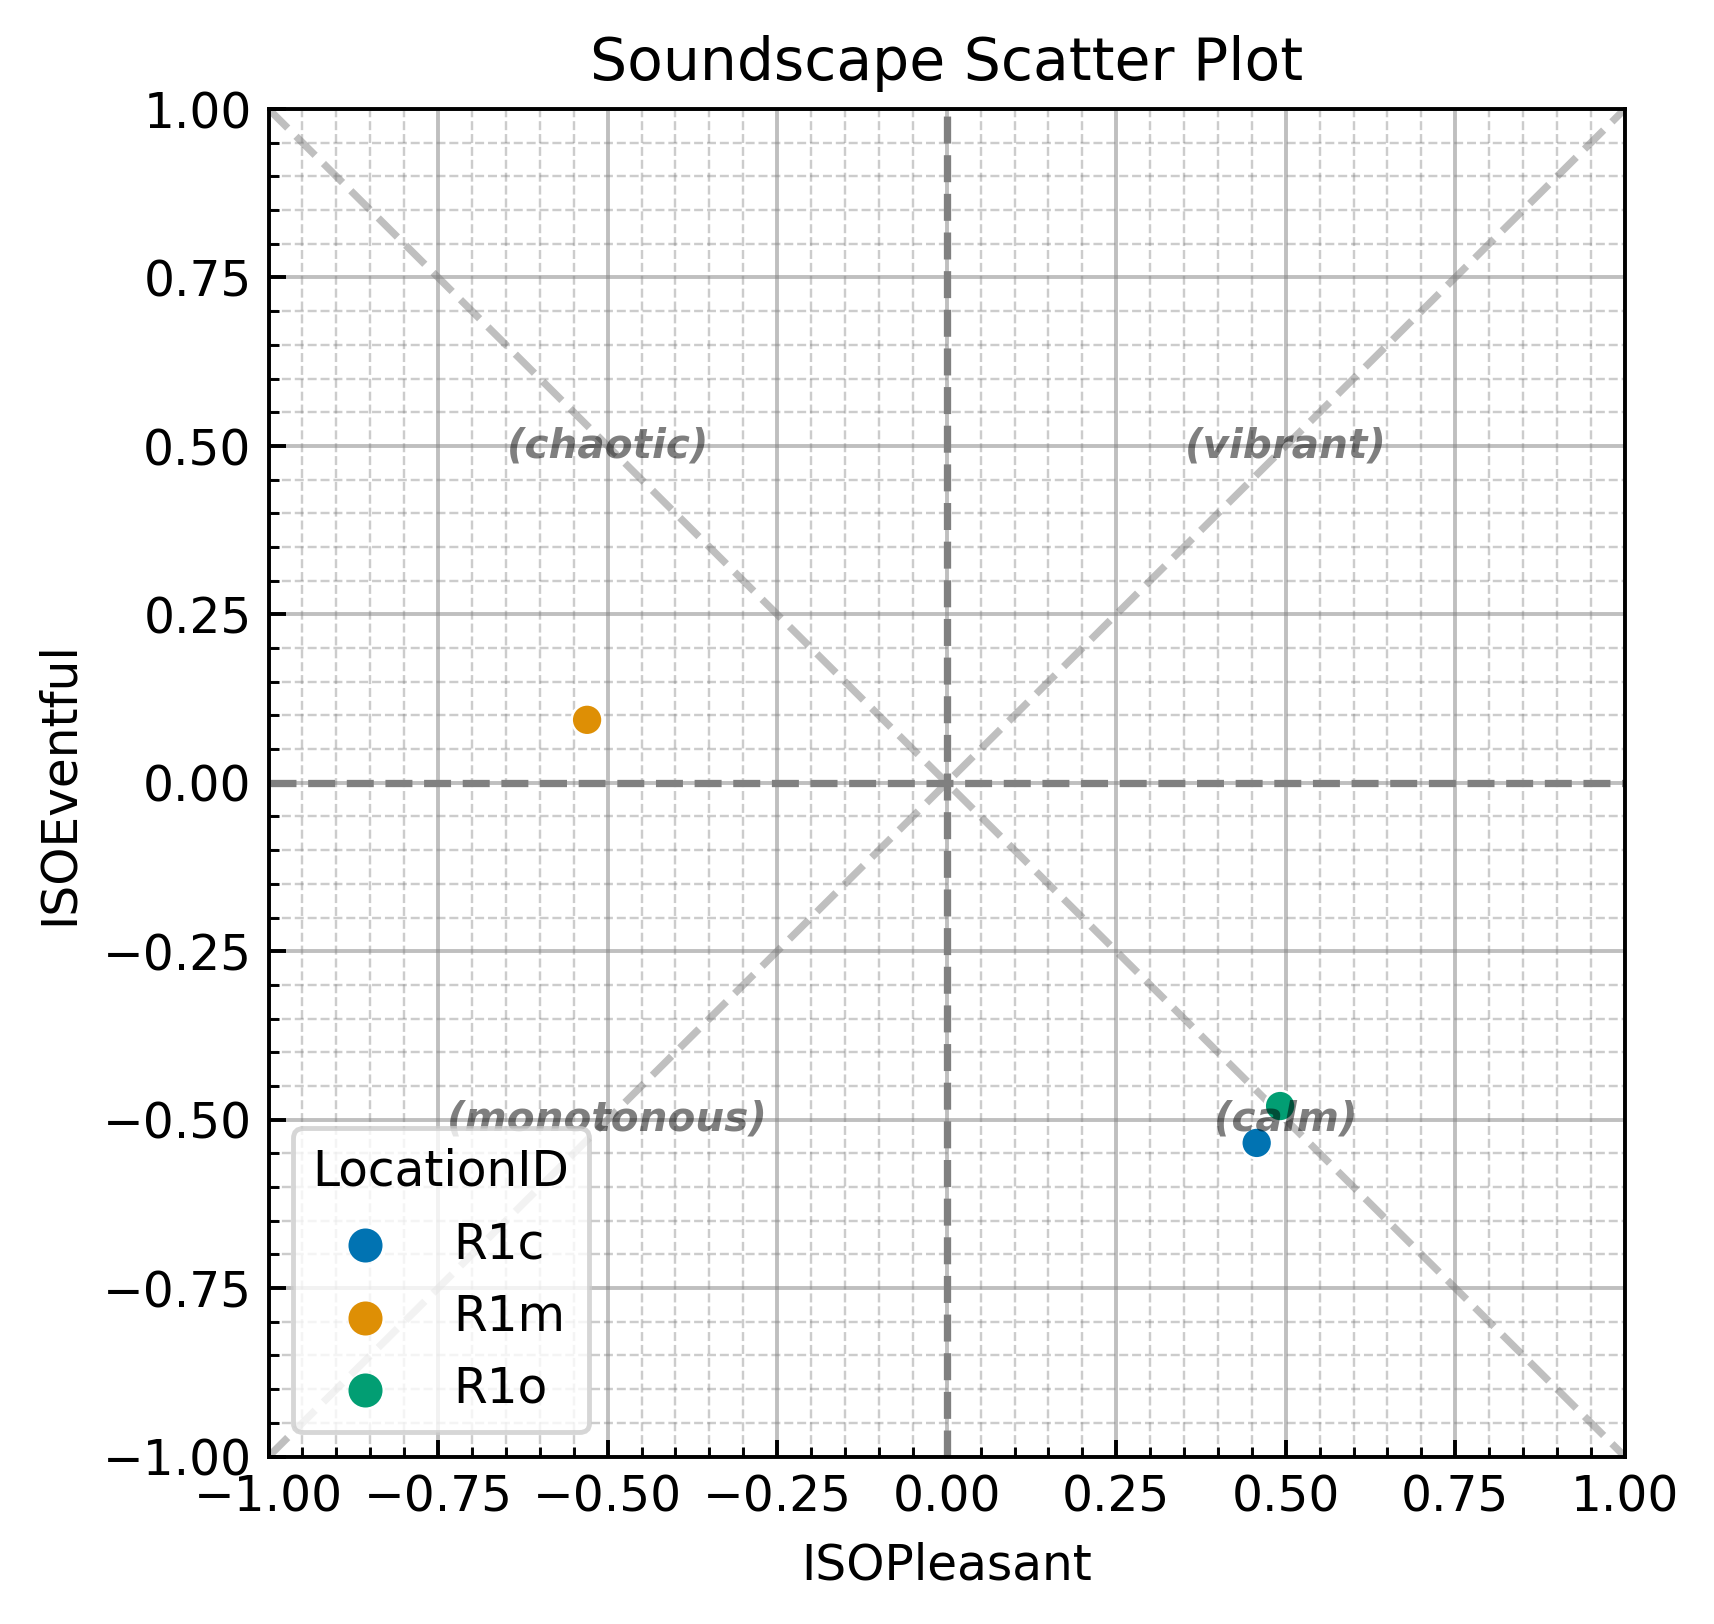

In [11]:
means = df.isd.mean_responses(group="LocationID")
means = means.sspy.add_paq_coords()
means.sspy.scatter(hue="LocationID", s=40, legend=True, diagonal_lines=True,)

# Test

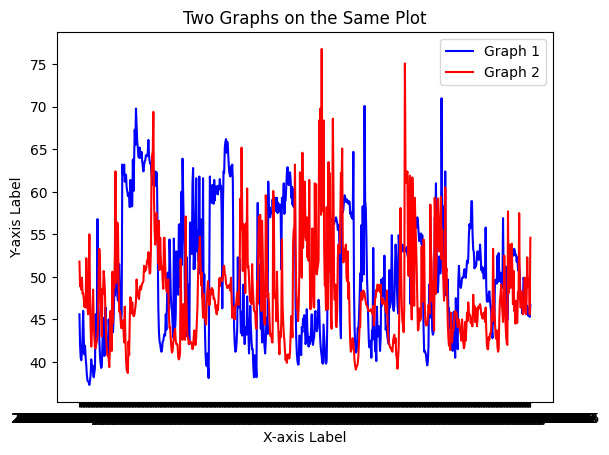

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_excel('C:/Users/fspintern1/Desktop/Internship - Hussam/Intern/Digital Workflow/T.xlsx')

# Plot the first graph
plt.plot(data['D1'], data['V1'], label='Graph 1', color='blue')

# Plot the second graph
plt.plot(data['D2'], data['V2'], label='Graph 2', color='red')

# Add labels, title, and grid
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Two Graphs on the Same Plot')

# Add legend to distinguish between the two graphs
plt.legend()

# Show the plot
plt.show()
